In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
#dados das eleições dos anos de 2006 e 2010
data = pd.read_csv("../data/train.csv")

#removendo variáveis irrelevantes
data = data.drop(columns=['sequencial_candidato', 'nome'])

#selecionando atributos numéricos
numeric_feats = data.dtypes[data.dtypes != "object"].index

#normalizando variáveis numéricas
data[numeric_feats] = np.log1p(data[numeric_feats])

#dummy das variáveis categoricas
X_train = data.drop(columns=['situacao'])
X_train = pd.get_dummies(X_train)
#dumy da variável alvo, eleito = 1 e nao_eleito = 0
Y_train = data.situacao
Y_train = Y_train.replace(['nao_eleito', 'eleito'], [0, 1])

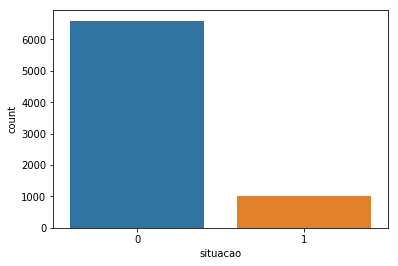

In [3]:
#plotando distribuição da variável alvo
sns.countplot(Y_train)            

As classes estão claramente desbalanceadas, essa diferença pode enviesar a aprendizagem do modelo.Isso pode ser tratrado por meio de técnicas de `Under-sampling`.

In [4]:
#Função para calcular o AUC-Precision&Recall na validação cruzada
from sklearn.model_selection import cross_val_score
def f1_cv(model):
    f1 = cross_val_score(model, X_train, Y_train, scoring='f1', cv=5)
    return(f1)

### Regressão Logistíca

In [5]:
from sklearn.linear_model import LogisticRegression
lambdas = np.arange(0.01,2,0.01).tolist()

cv_logRegression = [f1_cv(LogisticRegression(solver="lbfgs", max_iter=10000, C=lbd, random_state=1)).mean()
                    for lbd in lambdas]
cv_logRegression = pd.Series(cv_logRegression, index = lambdas)

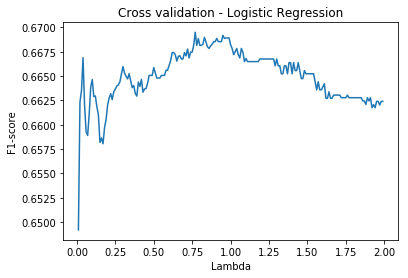

O melhor alpha é 0.77, com F1 = 0.669500791075


In [6]:
import matplotlib.pyplot as plt
cv_logRegression.plot(title = "Cross validation - Logistic Regression")
plt.xlabel("Lambda")
plt.ylabel("F1-score")
plt.show()
print("O melhor alpha é {0}, com F1 = {1}".format(cv_logRegression.idxmax(), cv_logRegression.max()))

### KNN

A melhor quantidade de vizinhos é 17, com F1 = 0.625597053773


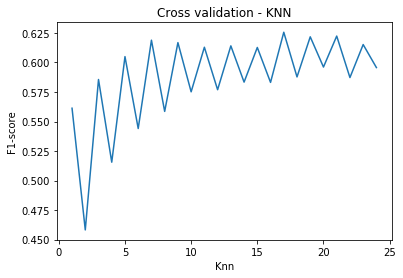

In [7]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier
neighbors = np.arange(1,25,1).tolist()
cv_knn = [f1_cv(KNeighborsClassifier(n_neighbors=neighbor)).mean() 
            for neighbor in neighbors]
cv_knn = pd.Series(cv_knn, index = neighbors)

#plot do AUC-Precision&Recall na validação cruzada
cv_knn.plot(title = "Cross validation - KNN")
plt.xlabel("Knn")
plt.ylabel("F1-score")
print("A melhor quantidade de vizinhos é {0}, com F1 = {1}".format(cv_knn.idxmax(), cv_knn.max()))

### Decision Tree

A profundidade ideal é 1, com F1 = 0.690871188568


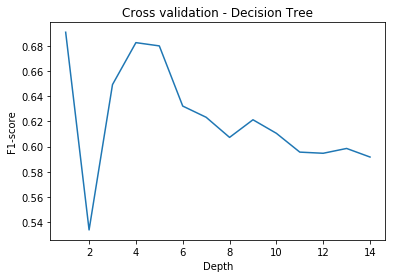

In [8]:
from sklearn import tree
depths = np.arange(1,15,1).tolist()
cv_tree = [f1_cv(tree.DecisionTreeClassifier(max_depth = depth)).mean() 
            for depth in depths]
cv_tree = pd.Series(cv_tree, index = depths)

#plot do AUC-Precision&Recall na validação cruzada
cv_tree.plot(title = "Cross validation - Decision Tree")
plt.xlabel("Depth")
plt.ylabel("F1-score")
print("A profundidade ideal é {0}, com F1 = {1}".format(cv_tree.idxmax(), cv_tree.max()))

Neste caso é claro o viés causado pelo desbalanceamento das classes, a melhor profundidade 

### Adaboost

A quantidade de árvores ideal é 22, com F1 = 0.710213445615


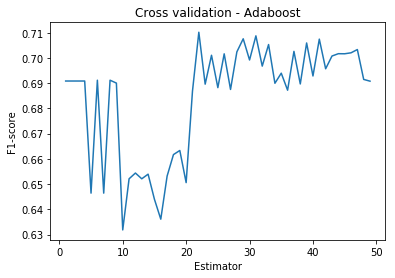

In [11]:
from sklearn.ensemble import AdaBoostClassifier
estimators = np.arange(1,50,1).tolist()
cv_ada =  [f1_cv(AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1), 
                                    algorithm="SAMME", 
                                    n_estimators=estimator)).mean() 
            for estimator in estimators]
cv_ada = pd.Series(cv_ada, index = estimators)

#plot do AUC-Precision&Recall na validação cruzada
cv_ada.plot(title = "Cross validation - Adaboost")
plt.xlabel("Estimator")
plt.ylabel("F1-score")
print("A quantidade de árvores ideal é {0}, com F1 = {1}".format(cv_ada.idxmax(), cv_ada.max()))


# oioioioi

As classes estão claramente desbalanceadas, essa diferença pode enviesar a aprendizagem do modelo. Isso pode ser tratrado por meio de técnicas de `Under-sampling`, neste caso vou utilizar NearMiss version 1 que pioriza a fronteira de decisão entre as classes.

from imblearn.under_sampling import NearMiss
nm = NearMiss(version=1)
X_train, Y_train = nm.fit_resample(X_train, Y_train)
sns.countplot(Y_train)